In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import tree
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from utils import  plot_corrs, plot_bars
np.random.seed(123)


import gym
from gym import spaces


In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

from collections import deque
import tensorflow as tf
import random

import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm

In [3]:
fname = ['W2_2019-11-19_09-59-25.csv', 'WIN_20200123_12_48_24_Pro.csv', 'WIN_20200129_14_38_54_Pro.csv',
         'WIN_20200129_14_56_13_Pro.csv', 'WIN_20200129_15_10_31_Pro.csv', 'WIN_20200301_20_18_27_Pro.csv',
         'WIN_20200320_18_43_50_Pro.csv']
         
df = pd.read_csv(fname[0])
df2 = pd.read_csv(fname[1])
df = df.append(df2)
df2 = pd.read_csv(fname[2])
df = df.append(df2)
df2 = pd.read_csv(fname[3])
df = df.append(df2)
df2 = pd.read_csv(fname[4])
df = df.append(df2)
df_test = pd.read_csv(fname[5])
feature_cols = ['Neutrality', 'Happy','Surprise','Fear', 'Disgust', 'Anger', 'Sadness', 'label']

In [4]:
df = df[df['label'] != 'Null']
df_test = df_test[df_test['label'] != 'Null']

In [5]:
df = df[df['label'] != 'Neutral']
df_test = df_test[df_test['label'] != 'Neutral']

In [6]:
df.loc[df.label == 'Dissonance', 'label'] = 0.0
df.loc[df.label == 'True', 'label'] = 1.0


In [7]:
df.sample(4)

,ID,TimeStamp,Neutrality,Happy,Surprise,Fear,Disgust,Anger,Sadness,Positive Sentiment,Negative Sentiment,Experience,Activation,Emotional Score,Subemotion,Start_t,End_t,Question,label
19232,1585841615927,00:10:46.600557,0.788,0.091,0.001,0.001,0.006,0.004,0.110,0.091,0.121,-0.029,0.212,0.431,NaN,00:10:44,00:10:47,one of the worst things a person could do is h...,1
8038,1585841615927,00:04:30.240208,0.724,0.212,0.002,0.001,0.004,0.013,0.044,0.214,0.062,0.151,0.276,0.774,Agrado,00:04:28,00:04:32,one of the worst things a person could do is h...,0
10018,1585841615927,00:05:36.300777,0.923,0.034,0.001,0.000,0.002,0.003,0.037,0.034,0.043,-0.009,0.077,0.444,Agrado,00:05:33,00:05:42,participant,0
18930,1585841615927,00:10:36.600403,0.902,0.030,0.003,0.001,0.008,0.028,0.029,0.032,0.065,-0.033,0.098,0.331,Agrado,00:10:32,00:10:38,participant,1


In [8]:
X = np.array(df.loc[:, feature_cols]).astype(np.float32)


In [9]:
# Set the seed for reproducible result
np.random.seed(1000)

randomDim = 3 

In [10]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(4, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(8, activation='sigmoid'))
#generator.compile(loss='binary_crossentropy', optimizer=adam)



In [11]:
discriminator = Sequential()
discriminator.add(Dense(16, input_dim=8, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [12]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

In [13]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    

In [14]:
def train(X_train, epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            #print (np.shape(imageBatch), np.shape(generatedImages))
            X = np.concatenate([imageBatch, generatedImages])
            #print(X)

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            #print(X,yDis, isinstance(X[0], list))
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        #if e == 1 or e % 20 == 0:
         #   saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

In [15]:
X

array([[0.385, 0.541, 0.005, ..., 0.004, 0.061, 0.   ],
       [0.34 , 0.6  , 0.005, ..., 0.004, 0.047, 0.   ],
       [0.395, 0.531, 0.006, ..., 0.005, 0.056, 0.   ],
       ...,
       [0.001, 0.999, 0.   , ..., 0.   , 0.   , 1.   ],
       [0.001, 0.999, 0.   , ..., 0.   , 0.   , 1.   ],
       [0.001, 0.999, 0.   , ..., 0.   , 0.   , 1.   ]], dtype=float32)

Epochs: 200
Batch size: 125
Batches per epoch: 662
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------------

--------------- Epoch 198 ---------------
--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------


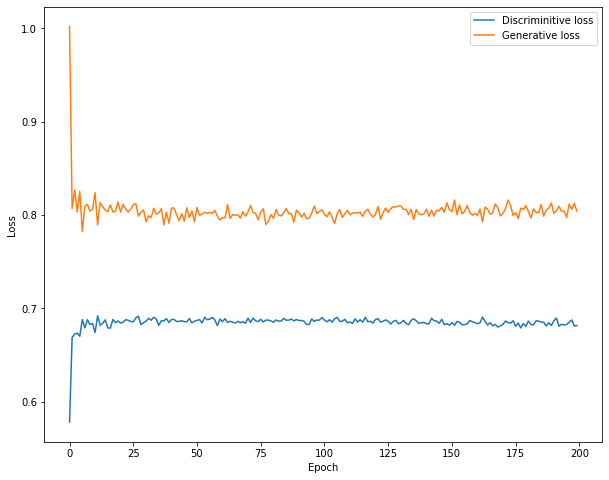

In [16]:
train(X, 200, 125)

In [17]:
X1 = df.loc[:, feature_cols[:-1]]
y1 = df.label

#X_test = df_test.loc[:, feature_cols[:-1]]
#y_test = df_test.label
le = preprocessing.LabelEncoder()
le.fit(list(set(df.label.values)))

y1 = le.transform(y1)
#y_test = le.transform(y_test)

#X_train, y_train = X, y

X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=1)

model = RandomForestClassifier() #svm.SVC(gamma=0.001)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [18]:
X_test

,Neutrality,Happy,Surprise,Fear,Disgust,Anger,Sadness
14743,0.892,0.012,0.011,0.002,0.009,0.023,0.052
19699,0.472,0.497,0.002,0.001,0.004,0.004,0.021
22859,0.952,0.002,0.005,0.000,0.003,0.003,0.035
8196,0.372,0.594,0.009,0.002,0.001,0.003,0.020
9926,0.013,0.985,0.002,0.000,0.000,0.000,0.001
...,...,...,...,...,...,...,...
13909,0.921,0.045,0.003,0.001,0.002,0.004,0.025
20669,0.531,0.406,0.005,0.002,0.008,0.007,0.041
5933,0.833,0.018,0.006,0.003,0.005,0.024,0.112
19641,0.900,0.023,0.003,0.001,0.003,0.005,0.066


In [19]:
noise = np.random.normal(0, 1, size=[1, randomDim])
obs = generator.predict(noise)
print(obs[:, :-1].shape)
model.predict(obs[:, :-1])

(1, 7)


array([1])

In [20]:
obs[:,-1] > 0.7

array([ True])

### RL Agent

In [21]:
class CustomEnv(gym.Env):
    """Custom Environment that follows gym interface"""
    def __init__(self):
        super(CustomEnv, self).__init__()    # Define action and observation space
        # They must be gym.spaces objects    # Example when using discrete actions:
        self.action_space = spaces.Discrete(2)    # Example for using image as input:
        self.observation_space = spaces.Box(low=0, high=1, shape=
                    (1, 8), dtype=np.float64)
        self.observation = np.zeros((1,8), dtype=np.float64)

    def step(self, action):
        # Execute one time step within the environment
        self.current_step += 1
        thresh = 0.6
        obs = self.observation
        #print(obs)
        label = obs[:,-1] > thresh
        pred = model.predict(obs[:, :-1]) > thresh
        #print(pred, action)
        reward = 1 if pred == action else 0
        done = self.current_step == 100  
        obs = generator.predict(noise) 
        return obs, reward, done, {}
    
    
    def reset(self):
        # Reset the state of the environment to an initial state
        noise = np.random.normal(0, 1, size=[1, randomDim])
        obs = generator.predict(noise)
        self.current_step = 0
        return obs
  

In [22]:

class DQN():
    def __init__(self, batch_size=64):
        self.memory = deque(maxlen=5000)
        self.env = CustomEnv()
        input_size = self.env.observation_space.shape[0]
        action_size = self.env.action_space.n
        self.batch_size = batch_size
        self.gamma = 1.0
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        alpha=0.01
        alpha_decay=0.01
        
       
        
        alpha=0.01
        alpha_decay=0.01
              
        # Init model
        self.model = Sequential()
        self.model.add(Dense(16, input_dim=8, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        self.model.add(LeakyReLU(0.2))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(action_size, activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(lr=alpha, decay=alpha_decay))
        self.model_target = tf.keras.models.clone_model(self.model)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state,action, reward, next_state, done))
        
    def choose_action(self, state, epsilon):
        if np.random.random() <= epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.model.predict(state))




    def replay(self, batch_size):
        x_batch, y_batch = [], []
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            y_target = self.model_target.predict(state)
            y_target[0][action] = reward if done else reward + self.gamma * np.max(self.model.predict(next_state)[0])
            x_batch.append(state[0])
            y_batch.append(y_target[0])
        
        self.model.fit(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch), verbose=0)
        #epsilon = max(epsilon_min, epsilon_decay*epsilon) # decrease epsilon
       

    def train(self):
        scores = deque(maxlen=100)
        avg_scores = []
        

        for e in range(EPOCHS):
            state = self.env.reset()
            done = False
            i = 0
            while not done:
                action = self.choose_action(state,self.epsilon)
                next_state, reward, done, _ = self.env.step(action)
                #print(reward,done)
                self.remember(state, action, reward, next_state, done)
                state = next_state
                self.epsilon = max(self.epsilon_min, self.epsilon_decay*self.epsilon) # decrease epsilon
                i += reward

            scores.append(i)
            mean_score = np.mean(scores)
            avg_scores.append(mean_score)
            #if mean_score >= 8:
            #    print('Solved after {} trials ✔'.format(e))
                #return avg_scores
            if e % 10 == 0:
                print('[Episode {}] - Average Score: {}.'.format(e, mean_score))
                self.model_target.set_weights(self.model.get_weights())

            self.replay(self.batch_size)
        
        #print('Did not solve after {} episodes 😞'.format(e))
        return avg_scores

In [23]:
agent = DQN()
agent.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


In [24]:
agent.model_target.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


In [25]:
EPOCHS = 200
scores = agent.train()

[Episode 0] - Average Score: 55.0.
[Episode 10] - Average Score: 90.72727272727273.
[Episode 20] - Average Score: 94.95238095238095.
[Episode 30] - Average Score: 96.54838709677419.
[Episode 40] - Average Score: 97.34146341463415.
[Episode 50] - Average Score: 97.76470588235294.
[Episode 60] - Average Score: 98.0327868852459.
[Episode 70] - Average Score: 98.21126760563381.
[Episode 80] - Average Score: 98.32098765432099.
[Episode 90] - Average Score: 98.47252747252747.
[Episode 100] - Average Score: 99.02.
[Episode 110] - Average Score: 99.56.
[Episode 120] - Average Score: 99.55.
[Episode 130] - Average Score: 99.55.
[Episode 140] - Average Score: 99.53.
[Episode 150] - Average Score: 99.55.
[Episode 160] - Average Score: 99.58.
[Episode 170] - Average Score: 99.61.
[Episode 180] - Average Score: 99.65.
[Episode 190] - Average Score: 99.59.
Did not solve after 199 episodes 😞


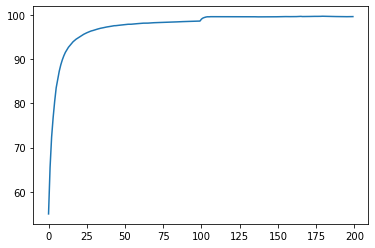

In [26]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

In [31]:
dff = pd.DataFrame(list(zip(dLosses, gLosses)), columns=['DLoss', 'GLoss'])

In [32]:
dff.head()

,DLoss,GLoss
0,0.578392,1.001692
1,0.668881,0.807068
2,0.672729,0.826936
3,0.673578,0.803506
4,0.670208,0.825282


In [33]:
dff.to_csv('ganLosses.csv', encoding='utf-8', index=False)

In [35]:
dff_rl = pd.DataFrame(scores, columns=['RLScore'])

In [36]:
dff_rl.head()

,RLScore
0,55.000000
1,65.500000
2,72.333333
3,76.750000
4,80.400000


In [37]:
dff_rl.to_csv('rl_score.csv', encoding='utf-8', index=False)

In [38]:
agent.model.save("rl_agent_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rl_agent_model/assets


In [39]:
generator.save("GAN_generator")

INFO:tensorflow:Assets written to: GAN_generator/assets


In [40]:
discriminator.save("GAN_discriminator")

INFO:tensorflow:Assets written to: GAN_discriminator/assets


In [45]:
y_pred = agent.choose_action(X[0],1)

In [46]:
y_pred

0

In [47]:
X[0]

array([0.385, 0.541, 0.005, 0.002, 0.003, 0.004, 0.061, 0.   ],
      dtype=float32)

In [48]:
y_pred = [agent.choose_action(X[i],1) for i in range(len(X))]

In [50]:
y_true = [X[i,-1] for i in range(len(X)) ]

In [53]:
accuracy_score(y_true, y_pred)

0.4994325453360056

<AxesSubplot:>

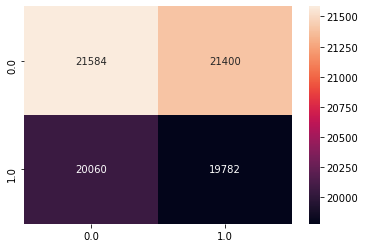

In [54]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d",
        xticklabels= list(set(df.label.values)),
        yticklabels=list(set(df.label.values)))